CamShift
- Meanshift 의 업그레이드 버전
- 객체가 크기가 바뀌거나 회전해도 추적가능
- MeanShift와 뭐가 차이나요? MeanShift 는 고정크기 박스이나, CamShift는 적응형 크기, 회전 가능한 박스

In [45]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # Colab 환경에서 이미지 표시를 위한 함수 임포트
import time # 출력 속도 조절을 위한 time 모듈 임포트

# --- 1. 변수 초기 설정 ---
roi_hist = None # 추적 객체 히스토그램 저장 변수
win_name = 'CamShift Tracking' # 화면 표시 창 이름 (Colab에서는 디버깅용)

# CamShift에 필요한 초기 추적 영역 좌표를 전역으로 초기화
# NOTE: 이 값을 수정하여 추적할 객체의 초기 위치와 크기를 설정할 수 있습니다.
# (x, y) = 시작 좌표, (w, h) = 너비, 높이
x, y, w, h = 1580 ,400,100,100
# (100,250)
# CamShift 중지 요건 (Termination Criteria)
# (오차(EPS) 또는 반복 횟수(COUNT) 중 하나라도 충족되면 중지)
termination = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
# 10: 최대 반복 회수, 1:오차 허용치

In [46]:
# --- 2. 비디오 캡처 설정 ---
# NOTE: Colab에서 이 코드를 실행하기 전에, 'top-down.mp4' 파일을 Colab 환경에 업로드해야 합니다.
video_path = '/home/kim/Desktop/AI_cours/data/top-down.mp4'
cap = cv2.VideoCapture(video_path) # 비디오 캡처 객체 생성
delay = int(1000/24) # 딜레이 설정 (약 41ms)

if not cap.isOpened():
    print("오류: 비디오 파일을 열 수 없습니다. 파일을 업로드했는지 확인하세요.")
    exit()

# Colab 환경을 위해 프레임 처리 개수를 제한하고 출력 주기를 설정합니다.
frame_count = 0
MAX_FRAMES_TO_PROCESS = 150 # 최대 150 프레임만 처리
DISPLAY_EVERY_N_FRAMES = 20 # 20 프레임마다 결과 출력

print(f"CamShift 추적 시작 (최대 {MAX_FRAMES_TO_PROCESS} 프레임, {DISPLAY_EVERY_N_FRAMES} 프레임마다 출력)...")

CamShift 추적 시작 (최대 150 프레임, 20 프레임마다 출력)...


In [47]:
# --- 2. 비디오 캡처 설정 ---
# NOTE: Colab에서 이 코드를 실행하기 전에, 'top-down.mp4' 파일을 Colab 환경에 업로드해야 합니다.
video_path = '/home/kim/Desktop/AI_cours/data/top-down.mp4'
cap = cv2.VideoCapture(video_path) # 비디오 캡처 객체 생성
delay = int(1000/24) # 딜레이 설정 (약 41ms)

if not cap.isOpened():
    print("오류: 비디오 파일을 열 수 없습니다. 파일을 업로드했는지 확인하세요.")
    exit()

# Colab 환경을 위해 프레임 처리 개수를 제한하고 출력 주기를 설정합니다.
frame_count = 0
MAX_FRAMES_TO_PROCESS = 150 # 최대 150 프레임만 처리
DISPLAY_EVERY_N_FRAMES = 20 # 20 프레임마다 결과 출력

print(f"CamShift 추적 시작 (최대 {MAX_FRAMES_TO_PROCESS} 프레임, {DISPLAY_EVERY_N_FRAMES} 프레임마다 출력)...")

# 3. 첫 프레임에서 ROI 히스토그램 등록
ret, frame = cap.read()
if not ret:
    print("오류: 첫 프레임을 읽을 수 없습니다.")
    exit()

if w > 0 and h > 0: # 유효한 ROI 설정된 경우에만 히스토그램 계산
    # 1. 초기 추적 대상 영역(ROI) 추출 >> hsv color 변경
    roi = frame[y:y+h, x:x+w]
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # 2. 마스크 생성 : ROI 히스토그램 계산 시 노이즈 픽셀 제외(채도/명도 낮은 픽셀 제외)

    mask = cv2.inRange(roi_hsv, np.array((0.,70.,70.)),np.array((180.,200.,200.)))

    # mask = cv2.inRange(roi_hsv, np.array((0.,50.,50.)),np.array((180.,255.,255.)))

    # 3. ROI의 H(색상) 채널에 대한 히스토그램 계산 및 정규화
    # mask 사용, 히스토그램 계산 (cv2.calcHist)
    roi_hist = cv2.calcHist([roi_hsv], [0], mask, [180],[0, 180])
    # [0] : Hue, [180]: bin 개수 ,[0, 180] 값의 범위 (hue 범위: 0-179)
    cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
    # roi_hist (first) : 원본 배열(원본 히스토그램), roi_hist(second): 정규화된 배열
    # >> 여기서는 원본 히스토그램 덮어 씌움
    # 0, 255 : 히스토그램의 최소값 0, 최대값 255
    print(f'초기 추적대상 영역 설정 완료: (x={x}, y={y}, w={w}, h={h})')
else:
  print("오류")
  exit()



CamShift 추적 시작 (최대 150 프레임, 20 프레임마다 출력)...
초기 추적대상 영역 설정 완료: (x=1580, y=400, w=100, h=100)


In [48]:
import matplotlib.pyplot as plt

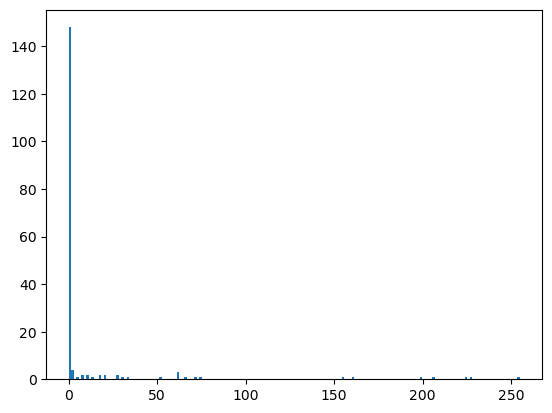

In [49]:
plt.hist(roi_hist.ravel(),180)
plt.show()

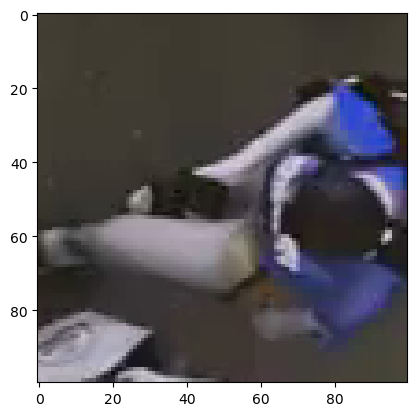

In [50]:
import matplotlib.pyplot as plt
plt.imshow(roi)

노이즈 필터링 마스크
- 마스크 역할
  - HSV 범위 필터링
  - 하한: (0., 50., 50.) : H는 모든 색상, S와 V는 50 이상
  - 상한: (180., 255., 255.)
  

  - HSV (Hue, Saturation, Value: 명도(색의 밝기))
    - Hue(색상) : 0-180도 (openCV 0-179, 0-255 표현)
    - Saturation(채도): 색의 순도, 0-1(0-255) 0에 가까울 수록 어두움
    - V(밝기) : 0-1(0-255) 0에 가까울 수록 어두움

  - S와 V는 50 이상
    - S(채도) < 50 : 회색(색이 거의 없다)
    - V(명도) < 50 : 너무 어둡다(검정에 가까워요)
    - 이런 픽셀들 추적 잘 안되요(방해가 되는 NOISE)

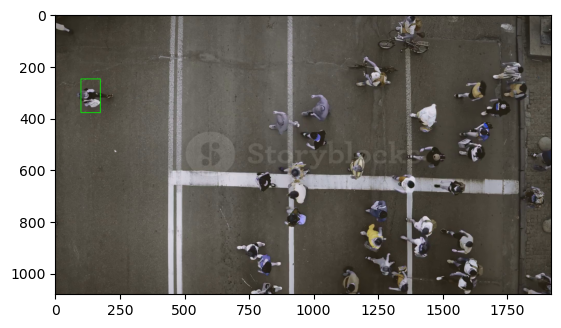

In [51]:
import matplotlib.pyplot as plt
video_path = '/home/kim/Desktop/AI_cours/data/top-down.mp4'
cap = cv2.VideoCapture(video_path) # 비디오 캡처 객체 생성
ret, frame = cap.read()
cv2.rectangle(frame,(100,250),(175,380),(0,255,0),2)
plt.imshow(frame)

In [52]:
# --- 2. 비디오 캡처 설정 ---
# NOTE: Colab에서 이 코드를 실행하기 전에, 'top-down.mp4' 파일을 Colab 환경에 업로드해야 합니다.
video_path = '/home/kim/Desktop/AI_cours/data/top-down.mp4'
cap = cv2.VideoCapture(video_path) # 비디오 캡처 객체 생성
delay = int(1000/24) # 딜레이 설정 (약 41ms)

if not cap.isOpened():
    print("오류: 비디오 파일을 열 수 없습니다. 파일을 업로드했는지 확인하세요.")
    exit()

# Colab 환경을 위해 프레임 처리 개수를 제한하고 출력 주기를 설정합니다.
frame_count = 0
MAX_FRAMES_TO_PROCESS = 150 # 최대 150 프레임만 처리
DISPLAY_EVERY_N_FRAMES = 20 # 20 프레임마다 결과 출력

print(f"CamShift 추적 시작 (최대 {MAX_FRAMES_TO_PROCESS} 프레임, {DISPLAY_EVERY_N_FRAMES} 프레임마다 출력)...")

# --- 4. 비디오 처리 루프 ---
while cap.isOpened() and frame_count < MAX_FRAMES_TO_PROCESS:
    ret, frame = cap.read()
    if not ret:
        break

    img_draw = frame.copy() # 원본 프레임 복사

    # --- 4-1. 추적 진행 ---
    if roi_hist is not None:
        # 1. 전체 영상 BGR -> HSV 컬러 변환
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # 2. 마스크 생성: 채도(S)와 명도(V)가 낮은 픽셀을 제외하여 노이즈 제거
        # target_mask = cv2.inRange(hsv, np.array((0., 50., 50.)), np.array((180., 255., 255.)))
        target_mask = cv2.inRange(hsv, np.array((0., 70., 70.)), np.array((180., 200., 200.)))

        # 3. Back Projection (역투영)
        # 전체 영상에 대해서 ROI 히스토그램을 역투영
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180],1)
        # [hsv] : 입력 이미지, 히스토그램을 적용할 대상 (전체 비디오 프레임(이미지))
        # [0]: 역투영에 사용할 채널 인덱스(hue) : 색상정보만 사용
        # roi_hist : 역투영의 기준
        # [0,180]: hue 의 값의 범위
        # 1 : scale (추가적인 스케일링 안하겠다. 그대로 사용)
        # dst : 단일채널(8bit) 이미지로 출력됨

        # 4. 역투영 결과에 마스크 곱하여 노이즈 영역의 확률을 0으로 만들어줘요
        dst = dst * target_mask

        # 5. 마스크가 적용된 역투영 결과와 이전 추적 위치로 CamShift 추적 실행
        ret, track_window = cv2.CamShift(dst, (x, y, w, h), termination)
        # ret : rotatedRect(회전된 사각형) 중심점(cx, cy) 크기 (w,h), 회전각 angle
        # track_window : 일반 bbox(bounding box) (x, y, w, h) >> 다음 프레임의 입력으로 사용됨

        # 6. 다음 프레임을 위한 track_window (x, y, w, h) 업데이트
        x, y, w, h = track_window

        # 7. 새로운 위치에 회전된 사각형 표시 (CamShift의 ret 사용)
        pts = cv2.boxPoints(ret)
        # 꼭지점 계산 ret의 회전 정보를 4개의 꼭지점 좌표로 변환
        # [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
        pts = np.int32(pts)
        cv2.polylines(img_draw, [pts], True, (0,255,0), 2)
        # True : 끝점과 시작점 연결

        # 8. 컬러영상과 역투영 영상을 통합해서 출력
        result = np.hstack((img_draw, cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)))

    else:
      cv2.putText(img_draw, 'Tracking Failed. Check ROI', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1,
                  cv2.LINE_AA)

      result = img_draw

    # 특정 간격의 프레임만 표시
    if frame_count % DISPLAY_EVERY_N_FRAMES == 0:
        print(f'프레임 {frame_count} 추적 중...')
        cv2.imshow('result',dst) # 추적 결과 프레임 표시
        if cv2.waitKey(1000) & 0xff == ord('q'):
           break
    #    time.sleep(1) # 잠시 대기

    frame_count += 1

cap.release()
cv2.destroyAllWindows()

CamShift 추적 시작 (최대 150 프레임, 20 프레임마다 출력)...
프레임 0 추적 중...
프레임 20 추적 중...
프레임 40 추적 중...
프레임 60 추적 중...
프레임 80 추적 중...
프레임 100 추적 중...
프레임 120 추적 중...
프레임 140 추적 중...


In [53]:
# eos